<a href="https://colab.research.google.com/github/Rpon17/plant_lover/blob/main/best.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 필요한 라이브러리 설치 및 YOLOv5 클론
!pip install roboflow
!git clone https://github.com/ultralytics/yolov5  # YOLOv5 저장소 클론
%cd yolov5
!pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.8 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
Cloning into 'yolov5'...
remote: Enumerating objects: 17022, done.
remote: Total 17022 (delta 0), reused 0 (delta 0), pack-reused 17022 (from 1)
Receiving objects: 100% (17022/17022), 15.62 MiB | 25.35 MiB/s, done.
Resolving deltas: 100% (11694/11694), done.
/content/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 879.0/879.0 kB 16.0 MB/s eta 0:00:00


In [2]:
# Step 1: Roboflow에서 데이터셋 다운로드
from roboflow import Roboflow
rf = Roboflow(api_key="3BzXsmqgRvmWY1ecSbNO")
project = rf.workspace("temp-3-pm4kq").project("leaf-izwde")
version = project.version(1)
dataset = version.download("yolov5")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to leaf-1 in yolov5pytorch:: 100%|██████████| 47291/47291 [00:08<00:00, 5349.44it/s]


In [3]:
# 데이터셋 위치 설정
base_dir = "/content/yolov5/leaf-1"

In [4]:
# Step 2: 데이터셋을 train, valid, test로 나누기 (7:2:1 비율)
import os
import random
import shutil

images_dir = os.path.join(base_dir, "train/images")
labels_dir = os.path.join(base_dir, "train/labels")


In [5]:
# 데이터를 나눌 새로운 디렉터리 생성
for split in ["train", "valid", "test"]:
    os.makedirs(f"{base_dir}/{split}/images", exist_ok=True)
    os.makedirs(f"{base_dir}/{split}/labels", exist_ok=True)

# 이미지 파일 리스트 가져오기
image_files = [f for f in os.listdir(images_dir) if f.endswith(".jpg")]

# 데이터셋을 섞음 (랜덤 셔플)
random.seed(42)  # 재현성을 위해 시드 설정
random.shuffle(image_files)

# 데이터셋 크기 계산 (7:2:1 비율)
total_images = len(image_files)
train_size = int(total_images * 0.7)
valid_size = int(total_images * 0.2)

# 데이터셋 분할
train_files = image_files[:train_size]
valid_files = image_files[train_size:train_size + valid_size]
test_files = image_files[train_size + valid_size:]

In [6]:
# 파일 이동 함수 정의
def move_files(file_list, dest_dir):
    for file_name in file_list:
        # 이미지 파일 이동
        src_image_path = os.path.join(images_dir, file_name)
        dest_image_path = os.path.join(dest_dir, "images", file_name)
        if os.path.exists(src_image_path):
            shutil.move(src_image_path, dest_image_path)
        # 라벨 파일 이동 (.txt 확장자)
        label_file = file_name.replace(".jpg", ".txt")
        src_label_path = os.path.join(labels_dir, label_file)
        dest_label_path = os.path.join(dest_dir, "labels", label_file)
        if os.path.exists(src_label_path):
            shutil.move(src_label_path, dest_label_path)

# 파일 이동 수행
move_files(train_files, f"{base_dir}/train")
move_files(valid_files, f"{base_dir}/valid")
move_files(test_files, f"{base_dir}/test")

print("데이터셋 분할이 완료되었습니다.")

데이터셋 분할이 완료되었습니다.


In [7]:
# 건강한 식물과 건강하지 않은 식물 클래스를 정의
healthy_classes = [
    'Apple leaf', 'Bell_pepper leaf', 'Blueberry leaf', 'Cassava_Healthy',
    'Cherry leaf', 'Corn Healthy', 'Eggplant___Healthy_fruit',
    'Eggplant___Healthy_leaf', 'Potato___Healthy_fruit', 'Potato___Healthy_leaf',
    'Soyabean leaf', 'Strawberry leaf', 'Tomato___Healthy_fruit',
    'Tomato___Healthy_leaf', 'Tomato_healthy', 'grape leaf'
]

unhealthy_classes = [
    'Anthracnose Fruit Rot', 'Apple Scab Leaf', 'Apple rust leaf',
    'Bell_pepper leaf spot', 'Blossom Blight', 'Cassava_Bacterial_Disease',
    'Cassava_Brown_Leaf_Spot', 'Cassava_Mosaic', 'Cassava_Root_Rot',
    'Chili___Anthracnose_fruit', 'Chili___Bacterial_leaf_spot',
    'Corn Gray leaf spot', 'Corn Smut', 'Corn Streak', 'Corn leaf blight',
    'Corn rust leaf', 'Corn_Blight', 'Corn_Brown_Spots', 'Corn_Cercosporiose',
    'Corn_Charcoal', 'Corn_Chlorotic_Leaf_Spot', 'Corn_Insects_Damages',
    'Corn_Mildiou', 'Corn_Purple_Discoloration', 'Corn_Rust', 'Corn_Smut',
    'Corn_Stripe', 'Corn_Violet_Decoloration', 'Corn_Yellow_Spots',
    'Corn_Yellowing', 'Eggplant___Colorado_potato_beetle', 'Eggplant___Fruit_rot',
    'Gray Mold', 'Leaf Spot', 'Peach leaf', 'Potato leaf early blight',
    'Potato leaf late blight', 'Potato___Alternaria_solani_leaf',
    'Potato___Common_scab_fruit', 'Potato___Phytopthora_infestans_leaf',
    'Potato___Virus_leaf', 'Powdery Mildew Fruit', 'Powdery Mildew Leaf',
    'Raspberry leaf', 'Squash Powdery mildew leaf', 'Tomato Early blight leaf',
    'Tomato Septoria leaf spot', 'Tomato leaf bacterial spot',
    'Tomato leaf late blight', 'Tomato leaf mosaic virus',
    'Tomato leaf yellow virus', 'Tomato mold leaf',
    'Tomato two spotted spider mites leaf', 'Tomato_Brown_Spots',
    'Tomato_Leaf_Curling', 'Tomato_Mildiou', 'Tomato_Mosaic',
    'Tomato___Anthracnose_fruit', 'Tomato___Bacterial_spot_leaf',
    'Tomato___Early_blight_leaf', 'Tomato___Late_blight_leaf',
    'Tomato___Leaf_mold', 'Tomato_bacterial_wilt', 'grape leaf black rot',
    'spider mites'
    ]

In [8]:
# 클래스 이름과 새 라벨 번호 맵핑
class_mapping = {name: 0 for name in healthy_classes}
class_mapping.update({name: 1 for name in unhealthy_classes})

In [9]:
# 라벨 디렉터리 목록 (train, valid, test)
label_dirs = [
    f'{base_dir}/train/labels',
    f'{base_dir}/valid/labels',
    f'{base_dir}/test/labels'
]


In [10]:
# 라벨 파일 업데이트
for label_dir in label_dirs:
    if os.path.exists(label_dir):
        for label_file in os.listdir(label_dir):
            if label_file.endswith('.txt'):
                file_path = os.path.join(label_dir, label_file)
                with open(file_path, 'r') as file:
                    lines = file.readlines()

                updated_lines = []
                for line in lines:
                    parts = line.strip().split()
                    class_id = int(parts[0])

                    try:
                        # 기존 클래스 아이디를 클래스 이름으로 변환
                        class_name = list(class_mapping.keys())[class_id]

                        # 건강한/비건강한으로 새로운 라벨로 변경
                        new_class_id = class_mapping[class_name]

                        # 기존 데이터를 업데이트된 클래스 아이디로 변경
                        updated_line = f"{new_class_id} " + " ".join(parts[1:]) + "\n"
                        updated_lines.append(updated_line)
                    except IndexError:
                        print(f"[Warning] 라벨 파일 {file_path}에서 유효하지 않은 클래스 아이디 {class_id}가 발견되었습니다.")

                # 업데이트된 내용을 파일에 다시 작성
                with open(file_path, 'w') as file:
                    file.writelines(updated_lines)


[Warning] 라벨 파일 /content/yolov5/leaf-1/train/labels/DCDl_p8UQAAf2hP_jpg.rf.4fe7b50bf4c0d51817d0fd980ab0c0f1.txt에서 유효하지 않은 클래스 아이디 84가 발견되었습니다.
[Warning] 라벨 파일 /content/yolov5/leaf-1/train/labels/grape-leaves2_jpg.rf.649157e95133b6576aa400443cb1c23a.txt에서 유효하지 않은 클래스 아이디 83가 발견되었습니다.
[Warning] 라벨 파일 /content/yolov5/leaf-1/train/labels/grape-leaves2_jpg.rf.649157e95133b6576aa400443cb1c23a.txt에서 유효하지 않은 클래스 아이디 83가 발견되었습니다.
[Warning] 라벨 파일 /content/yolov5/leaf-1/train/labels/grape-leaves2_jpg.rf.649157e95133b6576aa400443cb1c23a.txt에서 유효하지 않은 클래스 아이디 83가 발견되었습니다.
[Warning] 라벨 파일 /content/yolov5/leaf-1/train/labels/grape-leaves2_jpg.rf.649157e95133b6576aa400443cb1c23a.txt에서 유효하지 않은 클래스 아이디 83가 발견되었습니다.
[Warning] 라벨 파일 /content/yolov5/leaf-1/train/labels/grape-leaves2_jpg.rf.649157e95133b6576aa400443cb1c23a.txt에서 유효하지 않은 클래스 아이디 83가 발견되었습니다.
[Warning] 라벨 파일 /content/yolov5/leaf-1/train/labels/grape-leaves2_jpg.rf.649157e95133b6576aa400443cb1c23a.txt에서 유효하지 않은 클래스 아이디 83가 발견되었습니다.
[Warning] 라

In [11]:
# Step 4: data.yaml 파일 생성
data_yaml_content = f"""
train: {base_dir}/train/images
val: {base_dir}/valid/images
test: {base_dir}/test/images

nc: 2  # 클래스 수 (건강한 식물, 건강하지 않은 식물로 총 2개)
names: ['Healthy', 'Unhealthy']
"""

# data.yaml 파일 생성
with open(f'{base_dir}/data.yaml', 'w') as f:
    f.write(data_yaml_content)

print("data.yaml 파일이 생성되었습니다.")


data.yaml 파일이 생성되었습니다.


In [13]:
# Step 5: YOLOv5 모델 학습 실행
!python train.py --img 640 --batch 16 --epochs 50 --data {base_dir}/data.yaml --weights yolov5s.pt --name plant_health_classification --exist-ok


Traceback (most recent call last):
  File "/content/yolov5/train.py", line 34, in <module>
    import torch
  File "/usr/local/lib/python3.10/dist-packages/torch/__init__.py", line 368, in <module>
    from torch._C import *  # noqa: F403
  File "<frozen importlib._bootstrap>", line 216, in _lock_unlock_module
KeyboardInterrupt
^C


In [ ]:
from google.colab import drive
import shutil

# Google Drive 마운트
drive.mount('/content/drive')

# 모델 파일을 Google Drive로 복사
model_path = '/content/yolov5/runs/train/plant_health_classification/weights/best.pt'
shutil.copy(model_path, '/content/drive/MyDrive/best.pt')

print("모델 파일이 Google Drive에 저장되었습니다.")


Mounted at /content/drive
모델 파일이 Google Drive에 저장되었습니다.


In [ ]:
!python val.py --weights /content/yolov5/runs/train/plant_health_classification/weights/best.pt --data /content/yolov5/leaf-1/data.yaml --task test --img 640


val: data=/content/yolov5/leaf-1/data.yaml, weights=['/content/yolov5/runs/train/plant_health_classification/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-378-g2f74455a Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
test: Scanning /content/yolov5/leaf-1/test/labels... 2071 images, 27 backgrounds, 0 corrupt: 100% 2071/2071 [00:00<00:00, 9443.04it/s]
test: New cache created: /content/yolov5/leaf-1/test/labels.cache
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 65/65 [00:17<00:00,  3.72it/s]
                   all       2071       4243      0.817       0.83

In [ ]:
!python detect.py --weights /content/yolov5/runs/train/plant_health_classification/weights/best.pt --img 640 --conf 0.25 --source /content/my_image.jpg --name detection_result


detect: weights=['/content/yolov5/runs/train/plant_health_classification/weights/best.pt'], source=/content/my_image.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=detection_result, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-378-g2f74455a Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
Traceback (most recent call last):
  File "/content/yolov5/detect.py", line 437, in <module>
    main(opt)
  File "/content/yolov5/detect.py", line 432, in main
    run(**vars(opt))
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/_con

In [ ]:
from google.colab import files
import shutil

# Step 1: 사용자에게 파일 업로드 요청
uploaded = files.upload()

# Step 2: 업로드된 파일을 YOLOv5의 detect.py 스크립트에서 사용할 수 있도록 경로 설정
# 업로드된 파일의 이름을 가져와 YOLOv5의 소스 디렉토리로 이동
for filename in uploaded.keys():
    shutil.move(filename, f'/content/{filename}')
    source_image_path = f'/content/{filename}'

# Step 3: YOLOv5 탐지 실행
!python detect.py --weights /content/yolov5/runs/train/plant_health_classification/weights/best.pt --img 640 --conf 0.25 --source {source_image_path} --name detection_result --save-txt --save-conf

# 탐지 결과를 저장한 결과 파일 확인
from PIL import Image
import IPython.display as display

detection_result_path = '/content/yolov5/runs/detect/detection_result'
# 탐지된 이미지를 표시
result_image_path = f'{detection_result_path}/{filename}'
img = Image.open(result_image_path)
display.display(img)


In [14]:
import os
import shutil
import numpy as np
from sklearn.metrics import confusion_matrix
from google.colab import drive


In [15]:
# Google Drive 마운트
drive.mount('/content/drive')


Mounted at /content/drive


In [26]:
# 실제 라벨과 예측된 라벨 리스트 생성
y_true = []
y_pred = []

# 라벨 디렉터리와 예측 디렉터리 설정
train_labels_dir = '/content/yolov5/leaf-1/train/labels'
pred_labels_dir = '/content/detection_train_results/train_results/labels'

# 실제 라벨과 예측된 라벨을 읽어와서 리스트로 저장
for label_file in os.listdir(train_labels_dir):
    if label_file.endswith('.txt'):
        true_label_path = os.path.join(train_labels_dir, label_file)
        pred_label_path = os.path.join(pred_labels_dir, label_file)

        # 실제 라벨 읽기
        with open(true_label_path, 'r') as file:
            lines = file.readlines()
            for line in lines:
                y_true.append(int(line.split()[0]))

        # 예측 라벨 읽기
        if os.path.exists(pred_label_path):
            with open(pred_label_path, 'r') as file:
                lines = file.readlines()
                for line in lines:
                    y_pred.append(int(line.split()[0]))
        else:
            # 예측 파일이 없으면 해당 이미지는 탐지되지 않았음을 의미하므로 y_pred에 0 추가 (즉, 탐지 실패한 경우)
            y_pred.extend([0] * len(lines))

# 길이 맞추기 - y_true와 y_pred의 길이가 다른 경우 오류를 방지하기 위한 조치
min_length = min(len(y_true), len(y_pred))
y_true = y_true[:min_length]
y_pred = y_pred[:min_length]

# 혼동 행렬 계산
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

# TP, TN, FP, FN 출력
print(f"True Positives (TP): {tp}")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")


True Positives (TP): 17056
True Negatives (TN): 1924
False Positives (FP): 5488
False Negatives (FN): 6065


In [20]:
import os
import shutil

# 탐지된 결과를 Google Drive로 복사
output_images_dir = '/content/detection_train_results/train_results/crops'
output_drive_dir = '/content/drive/MyDrive/detection_train_results'

# 결과 디렉터리를 Google Drive로 복사
if not os.path.exists(output_drive_dir):
    os.makedirs(output_drive_dir)

for dir_name in os.listdir(output_images_dir):
    src_dir = os.path.join(output_images_dir, dir_name)
    dest_dir = os.path.join(output_drive_dir, dir_name)

    if os.path.isdir(src_dir):
        if os.path.exists(dest_dir):
            shutil.rmtree(dest_dir)  # 이미 존재하면 삭제
        shutil.copytree(src_dir, dest_dir)  # 디렉터리 전체 복사
    else:
        shutil.copy(src_dir, dest_dir)

print("탐지된 결과 이미지가 Google Drive에 저장되었습니다.")



탐지된 결과 이미지가 Google Drive에 저장되었습니다.


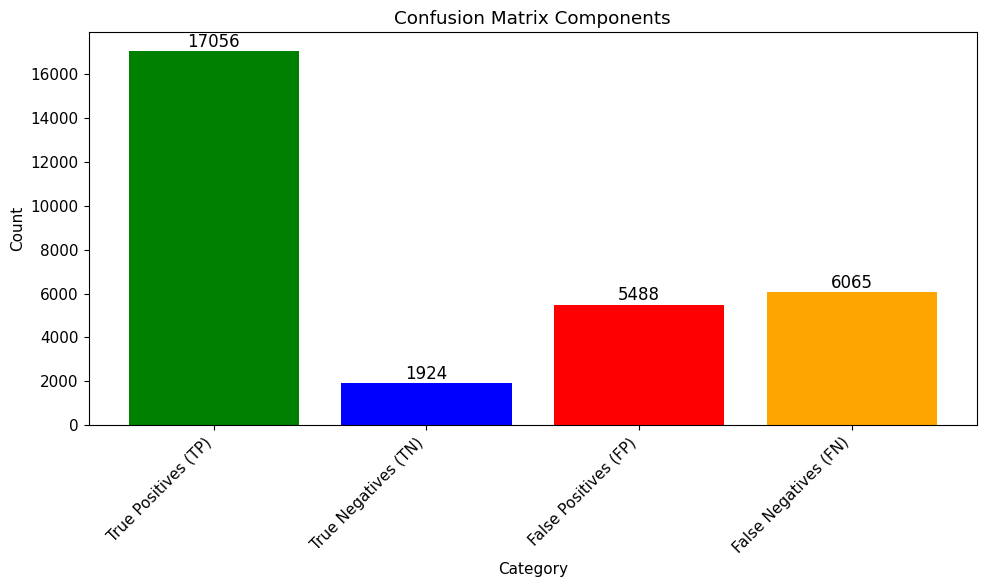

In [27]:
# 혼동 행렬 그래프 그리기
import matplotlib.pyplot as plt
import numpy as np

# 혼동 행렬 값
TP = tp
TN = tn
FP = fp
FN = fn

# 데이터 준비
categories = ['True Positives (TP)', 'True Negatives (TN)', 'False Positives (FP)', 'False Negatives (FN)']
values = [TP, TN, FP, FN]

# matplotlib 설정
%matplotlib inline

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.bar(categories, values, color=['green', 'blue', 'red', 'orange'])

# 그래프에 레이블 추가
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Confusion Matrix Components')
plt.xticks(rotation=45, ha='right')

# 값 표시
for i, v in enumerate(values):
    plt.text(i, v + 200, str(v), ha='center', fontsize=12)

plt.tight_layout()
plt.show()

Precision: 0.76
Recall: 0.74
F1 Score: 0.75


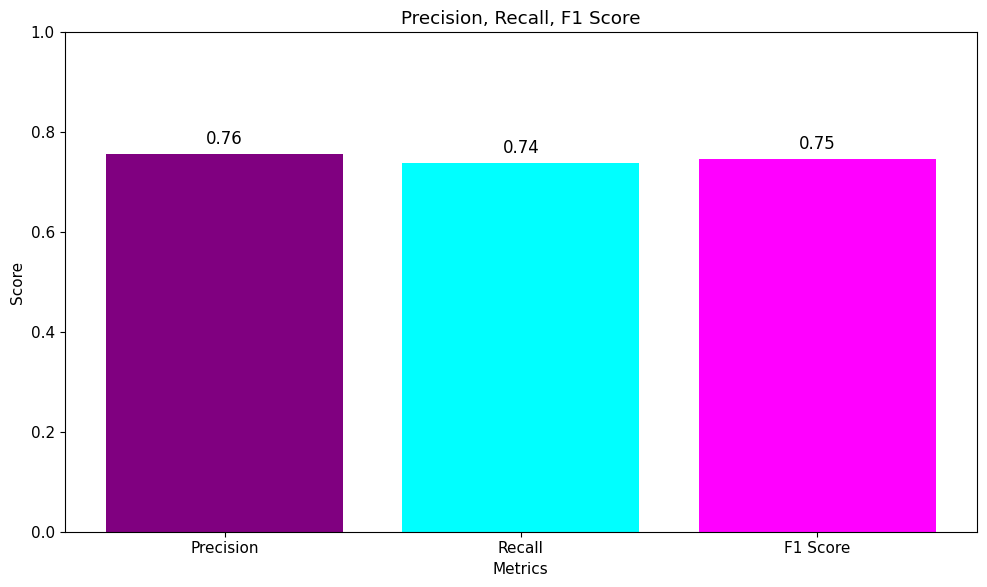

In [28]:
# 정밀도, 재현율, F1 점수 계산
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# 정밀도, 재현율, F1 점수 출력
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1_score:.2f}")

# 정밀도, 재현율, F1 점수 시각화
metrics_categories = ['Precision', 'Recall', 'F1 Score']
metrics_values = [precision, recall, f1_score]

plt.figure(figsize=(10, 6))
plt.bar(metrics_categories, metrics_values, color=['purple', 'cyan', 'magenta'])

# 그래프에 레이블 추가
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Precision, Recall, F1 Score')
plt.ylim(0, 1)

# 값 표시
for i, v in enumerate(metrics_values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=12)

plt.tight_layout()
plt.show()

In [29]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
